This notebook examines how to create a new fit_template for EIS data.
Here the focus will be the S VIII 198.55 line.

### The fit template

The line fitting in eispac is typically perfomed by providing a fit_template, which contains information about the fitting parameters (e.g. initial guesses, constrains, etc.). 

eispac contains a number of fit_templates for different lines, but not all lines have already a fit template. One such example is the S VIII 198.55 line.

The fit_templates are hdf5 files and they contain two main Groups, the 'template' and the 'parinfo'. These can be examined by looking at an existing template, like the one for Si VII 275.368.

In [12]:
import h5py

template_filename = 'si_07_275_368.1c.template.h5'
tmplt_dir = './Data/fit_templates'
template_filepath = tmplt_dir + '/' + template_filename
tmplt = eispac.read_template(template_filepath)


In [13]:
tmplt.parinfo

[{'fixed': 0,
  'limited': array([1, 0], dtype=int16),
  'limits': array([0., 0.]),
  'tied': array('', dtype='<U1'),
  'value': 2160.9863786158053},
 {'fixed': 0,
  'limited': array([1, 1], dtype=int16),
  'limits': array([275.32501398, 275.40529399]),
  'tied': array('', dtype='<U1'),
  'value': 275.3651539835592},
 {'fixed': 0,
  'limited': array([1, 1], dtype=int16),
  'limits': array([0.01910828, 0.05095541]),
  'tied': array('', dtype='<U1'),
  'value': 0.030653187366725062},
 {'fixed': 0,
  'limited': array([0, 0], dtype=int16),
  'limits': array([0., 0.]),
  'tied': array('', dtype='<U1'),
  'value': 36.302617504735665}]

In [14]:
tmplt.template

{'component': 1,
 'data_e': array([12.448081 , 11.079003 , 11.117625 , 12.303108 , 12.9370985,
        20.168133 , 31.033236 , 43.15835  , 49.15887  , 41.41116  ,
        28.831747 , 19.490063 ], dtype=float32),
 'data_x': array([275.18903, 275.21124, 275.23352, 275.25574, 275.278  , 275.30023,
        275.32245, 275.34473, 275.36694, 275.38922, 275.41144, 275.43365],
       dtype=float32),
 'data_y': array([  58.751583,   19.262491,   21.373722,   55.2766  ,   69.03847 ,
         267.3988  ,  858.55316 , 1732.588   , 2268.4558  , 1584.2301  ,
         711.0475  ,  241.27818 ], dtype=float32),
 'fit': array([2.16098638e+03, 2.75365154e+02, 3.06531874e-02, 3.63026175e+01]),
 'fit_back': 36.302617504735665,
 'fit_gauss': array([2.16098638e+03, 2.75365154e+02, 3.06531874e-02]),
 'line_ids': array(['Si VII 275.368'], dtype='<U14'),
 'n_gauss': 1,
 'n_poly': 1,
 'order': 1,
 'wmax': 275.45,
 'wmin': 275.168}

Based on the above I will try to create my own template for another line.
First fitting the data for an 'average' pixel, getting the fit parameters and then creating the 'template' and the 'parinfo'.

### Fitting the data 

In [1]:
import scipy.io as io
import eispac
import numpy as np 
import os 
import matplotlib.pyplot as plt


Data file,
   /home/alexandros/Dev/EIS_data_analysis/Data/eis_20110525_235841.data.h5
Header file,
   /home/alexandros/Dev/EIS_data_analysis/Data/eis_20110525_235841.head.h5
Found a wavelength 198.55 [Angstroms] in window 7
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


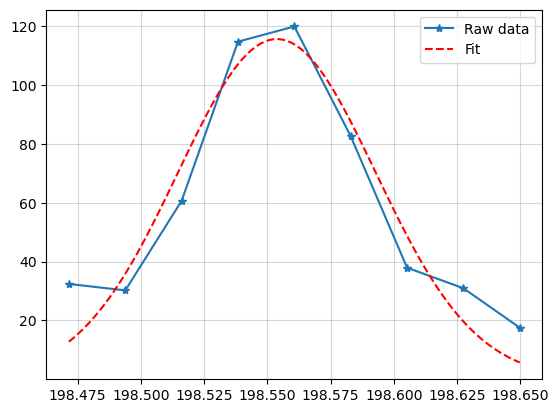

In [28]:
## Method 1 
# Use the astropy library and the LevMar method
from astropy import modeling

# Load the data 
data_dir = './Data'
data_name = 'eis_20110525_235841.data.h5'
data_filepath = os.path.join(data_dir,data_name)
data_cube = eispac.read_cube(data_filepath,198.550) #S VIII 

# Select a pixel
ix = 20#35#30#20
iy = 30#150#100#30 

# wvl = data_cube.wavelength[iy,ix,:]
# rawdata = data_cube.data[iy,ix,:]
# data_err = data_cube.uncertainty.array[iy, ix, :]

## Maunally reduce the wavelength extend for fitting,
# this is done to insure the fitting of only the line that I am 
# interested in. The extend of this wavelengt window depends on the 
# line profile at different positions.
wvl = data_cube.wavelength[iy,ix,:][7:-8]
rawdata = data_cube.data[iy,ix,:][7:-8]
data_err = data_cube.uncertainty.array[iy, ix, :][7:-8]

# Initial guesses 
amp_g = max(rawdata)
mean_g = np.mean(wvl)
std_g = np.std(wvl)

# Fitting
fitter = modeling.fitting.LevMarLSQFitter()
model = modeling.models.Gaussian1D(amplitude=amp_g,mean=mean_g,stddev=std_g)
fitted_model = fitter(model, wvl, rawdata)

# Plotting
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(wvl,rawdata,'*-',label='Raw data')
wvl_arr = np.linspace(min(wvl),max(wvl),100)
ax.plot(wvl_arr,fitted_model(wvl_arr),'r--',label='Fit')
ax.grid(alpha=0.5)
ax.legend()

### Create new template

The __template__ is a dictionairy and the __parinfo__ a list of dictionairies, from [here](https://github.com/USNavalResearchLaboratory/eispac/blob/7a480262aac6a45188f5c88865f1909424556d03/eispac/core/read_template.py#L10)

Update:
It is better to write the fit_template as an hdf5 file and then read that file with eispac.read_template.

In [30]:
## My template
model_params = fitted_model.parameters
# print(fitted_model.param_names)
background = 30. #manual selection for the time being  
my_fit = np.append(model_params,background)
fit_line_list = np.array(['S VIII 198.55'],dtype='S')#!!!
# dtype 'S' for zero terminated bytes.
# This dtype is not recommended in the numpy documentation but 
# here is used to reproduce exactly the format of existing templates
# https://numpy.org/doc/stable/reference/arrays.dtypes.html#arrays-dtypes-constructing


# #---Template---
# following the format of existing templates
my_SVIII_template = {'component':np.array([1],dtype=np.int16),
                    'data_e': data_err,
                    'data_x': wvl,
                    'data_y': rawdata,
                    'fit': my_fit,
                    'fit_back': np.array([my_fit[-1]]),
                    'fit_gauss': my_fit[0:-1],
                    'line_ids': fit_line_list,
                    'n_gauss':np.array([1],dtype=np.int16),
                    'n_poly':np.array([1],dtype=np.int16),
                    'order':np.array([1],dtype=np.int16),
                    'wmax':np.array([wvl[-1]],dtype=np.float32),
                    'wmin':np.array([wvl[-1]],dtype=np.float32)
                    }

# # ---Parinfo---
# I have selected the same limited and limits as in the Si VII template,
# but adjusting the wavelength limits 
tied = np.bytes_(['','','',''])
my_SVIII_parinfo = {'fixed':np.array([0,0,0,0]),
                    'limited':np.array([[1,0],[1,1],[1,1],[0,0]]),
                  'limits':np.array([[0.,0.],[wvl[0],wvl[-1]],
                                      [1.91082805e-02, 5.09554148e-02],
                                     [0.,0.]]),
                  'tied':tied,    
                  'value':my_fit}




In [31]:
## Write the parinfo and the template in an hdf5 file 
ff = h5py.File("my_S_VIII_template.h5", "w")

g1 = ff.create_group('template')
g2 = ff.create_group('parinfo')

for k in my_SVIII_template.keys():
    g1.create_dataset(k,data=my_SVIII_template[k])
    
for k in my_SVIII_parinfo.keys():
    g2.create_dataset(k,data=my_SVIII_parinfo[k])
    
ff.close()

In [40]:
## Read that file 
my_template_filename = 'my_S_VIII_template.h5'
my_tmplt_dir = os.getcwd()
my_template_filepath = my_tmplt_dir + '/' + my_template_filename
my_SVIII_tmplt = eispac.read_template(my_template_filepath)


See how the fit_template looks

In [41]:
my_SVIII_tmplt.central_wave

198.64981079101562

In [42]:
my_SVIII_tmplt.template

{'component': 1,
 'data_e': array([15.22971162, 14.79896409, 20.31741866, 27.54063768, 28.18494373,
        23.63522005, 16.53464067, 15.14905504, 11.98196332]),
 'data_x': array([198.47156975, 198.49385008, 198.5161304 , 198.53841068,
        198.56069095, 198.58297118, 198.60525139, 198.62753158,
        198.64981174]),
 'data_y': array([ 32.40841 ,  30.207262,  60.645855, 114.73739 , 119.88968 ,
         82.604546,  37.9142  ,  30.930925,  17.520248], dtype=float32),
 'fit': array([1.15623264e+02, 1.98553781e+02, 3.91580356e-02, 3.00000000e+01]),
 'fit_back': 30.0,
 'fit_gauss': array([1.15623264e+02, 1.98553781e+02, 3.91580356e-02]),
 'line_ids': array(['S VIII 198.55'], dtype='<U13'),
 'n_gauss': 1,
 'n_poly': 1,
 'order': 1,
 'wmax': 198.64981,
 'wmin': 198.64981}

In [43]:
my_SVIII_tmplt.parinfo

[{'fixed': 0,
  'limited': array([1, 0]),
  'limits': array([0., 0.]),
  'tied': array('', dtype='<U1'),
  'value': 115.62326411949641},
 {'fixed': 0,
  'limited': array([1, 1]),
  'limits': array([198.47156975, 198.64981174]),
  'tied': array('', dtype='<U1'),
  'value': 198.55378062187225},
 {'fixed': 0,
  'limited': array([1, 1]),
  'limits': array([0.01910828, 0.05095541]),
  'tied': array('', dtype='<U1'),
  'value': 0.03915803555640744},
 {'fixed': 0,
  'limited': array([0, 0]),
  'limits': array([0., 0.]),
  'tied': array('', dtype='<U1'),
  'value': 30.0}]

### Fit spectra with the new template

In [45]:
if __name__ == '__main__':
    # Read spectral window into an EISCube
    data_cube = eispac.read_cube(data_filepath, my_SVIII_tmplt.central_wave,
                                  apply_radcal=True) 
    
    
    # Fit the data, then save it to disk
    save_dir = data_dir + '/fit_res'
    fit_res = eispac.fit_spectra(data_cube, my_SVIII_tmplt, ncpu='max')
    save_filepaths = eispac.save_fit(fit_res, save_dir=save_dir)


Data file,
   /home/alexandros/Dev/EIS_data_analysis/Data/eis_20110525_235841.data.h5
Header file,
   /home/alexandros/Dev/EIS_data_analysis/Data/eis_20110525_235841.head.h5
Found a wavelength 198.65 [Angstroms] in window 7
INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
 + computing fits for 60 exposures, each with 512 spectra
 + running mpfit on 6 cores (of 6)


/home/alexandros/anaconda3/lib/python3.8/site-packages/eispac/core/fit_spectra.py:423: RuntimeWarning: invalid value encountered in divide
  rel_err = obs_errs/obs_cent




Finished computing fits!
   runtime : 0:01:28.279525
   29690 spectra fit without issues
   1030 spectra have < 7 good data points
   0 spectra have bad or invalid parameters
Saving EIS fit results...
   Directory: Data/fit_res
   Filenames: eis_20110525_235841.s__08_198_550.1c-0.fit.h5


### Examine the fit result

In [47]:
# Load the fit result
fit_res_dir = './Data/fit_res'
fit_res_name = 'eis_20110525_235841.s__08_198_550.1c-0.fit.h5'
fit_res_filepath = os.path.join(fit_res_dir,fit_res_name)
fit_res = eispac.read_fit(fit_res_filepath)

Reading fit result from, 
   ./Data/fit_res/eis_20110525_235841.s__08_198_550.1c-0.fit.h5


In [48]:
int_map = fit_res.get_map(0,'int')

INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


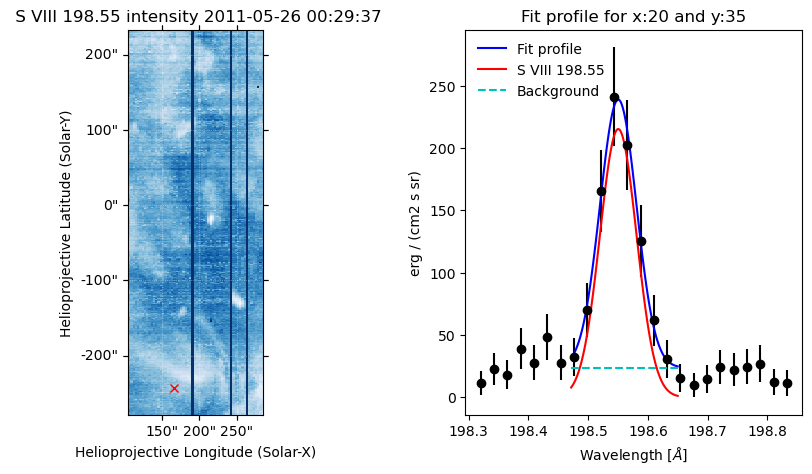

In [53]:
# Plot 
from helper_functions import plot_fit_profile as pfp 

# Select any pixel
ix = 20
iy = 35

fig = plt.figure(figsize=[10,5])
plot_grid = fig.add_gridspec(nrows=1, ncols=2, wspace=0.3)

# Intensity map
ax = fig.add_subplot(plot_grid[0,0],projection=int_map)
int_map.plot(axes=ax)
ax.plot(ix,iy,'rx')

# Fit result 
ax2 = fig.add_subplot(plot_grid[0,1])
pfp(data_cube,fit_res,iy,ix,ax2)